PARAMETTRES NECESSAIRES
--

In [ ]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'MyDrive/OLSPE'       # path to your project on Drive

drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)
!mkdir "{PROJECT_PATH}"    # in case we haven't created it already
%cd "{PROJECT_PATH}"

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/MyDrive/OLSPE’: File exists
/content/drive/MyDrive/OLSPE


In [ ]:
!pwd

/content/drive/MyDrive/OLSPE


In [ ]:
!ls

1. IMPORTATION DES LIBRARIES UTILISEES

In [ ]:
from IPython.display import HTML, Audio, display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
import io
from PIL import Image

from keras.models import Sequential, Model
from keras.layers import Flatten, Dropout, Activation, Permute
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
K.set_image_data_format( 'channels_last' )
from scipy.spatial.distance import cosine as dcos
from scipy.io import loadmat
import os
from multiprocessing.dummy import Pool
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from google.colab.patches import cv2_imshow
import PIL
import io
import html
import time
%matplotlib inline
import matplotlib.pyplot as plt
import  dlib 
import math

CONDITIONS GENERALES D'UTILISATIONS 
--

In [ ]:
import IPython
IPython.display.HTML(filename='/content/drive/MyDrive/OLSPE/Version Final/bouton.html')

IDENTIFICATION DU CANDIDAT
--

2. APPLICATION DE FILTRE SUR LA PHOTO ET DETECTION DU VISAGE AVEC CADRAGE


Cette méthode permet de trouver tous les visages qui sont dans une image, de les encadrer, puis de découper l’image autour du premier

In [ ]:
detector=dlib.get_frontal_face_detector()
predictor=dlib.shape_predictor("/content/drive/MyDrive/OLSPE/shape_predictor_68_face_landmarks.dat")

In [ ]:
def auto_crop_image(image):
  #On commence donc par charger notre fichier haarcascade et par le configurer 
  # en indiquant comment il doit fusionner les visages qu’il identifie.
    if image is not None:
        im = image.copy()
        # Load HaarCascade from the file with OpenCV
        faceCascade = cv2.CascadeClassifier("/content/drive/MyDrive/opencv/data/haarcascades_cuda/haarcascade_frontalface_default.xml")
        
        # Read the image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Detect faces in the image
        faces = faceCascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30)
        )
        faces = faceCascade.detectMultiScale(gray, 1.2, 5)
        
        # Dans un second temps on va tracer des rectangles autour de tous les visages trouvés 
        #et on va découper l’image autour du premier.

        if len(faces) > 0:
            # Draw a rectangle around the faces
            for (x, y, w, h) in faces:
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)        
            (x, y, w, h) = faces[0]
            center_x = x+w/2
            center_y = y+h/2
            height, width, channels = im.shape
            b_dim = min(max(w,h)*1.2,width, height)
            box = [center_x-b_dim/2, center_y-b_dim/2, center_x+b_dim/2, center_y+b_dim/2]
            box = [int(x) for x in box]
            # Crop Image
            if box[0] >= 0 and box[1] >= 0 and box[2] <= width and box[3] <= height:
                crpim = im[box[1]:box[3],box[0]:box[2]]
                crpim = cv2.resize(crpim, (224,224), interpolation = cv2.INTER_AREA)
                print("Found {0} faces!".format(len(faces)))
                return crpim, image, (x, y, w, h)
        faces=detector(gray)
        if faces is not None:
          i=np.zeros(shape=(image.shape), dtype=np.uint8)
        for face in faces:
          landmarks=predictor(gray, face)

          d_eyes=math.sqrt(math.pow(landmarks.part(36).x-landmarks.part(45).x, 2)+math.pow(landmarks.part(36).y-landmarks.part(45).y, 2))
          d1=math.sqrt(math.pow(landmarks.part(36).x-landmarks.part(30).x, 2)+math.pow(landmarks.part(36).y-landmarks.part(30).y, 2))
          d2=math.sqrt(math.pow(landmarks.part(45).x-landmarks.part(30).x, 2)+math.pow(landmarks.part(45).y-landmarks.part(30).y, 2))
          coeff=d1+d2

          a1=int(250*(landmarks.part(36).y-landmarks.part(45).y)/coeff)
          a2=int(250*(d1-d2)/coeff)
          cosb=min((math.pow(d2, 2)-math.pow(d1, 2)+math.pow(d_eyes, 2))/(2*d2*d_eyes), 1)
          a3=int(250*(d2*math.sin(math.acos(cosb))-coeff/4)/coeff)

          for n in range(0, 68):
            x=landmarks.part(n).x
            y=landmarks.part(n).y
            if n==30 or n==36 or n==45:
                cv2.circle(i, (x, y), 3, (255, 255, 0), -1)
            else:
                cv2.circle(i, (x, y), 3, (255, 0, 0), -1)
          print("{:+05d} {:+05d} {:+05d}".format(a1, a2, a3))
          
          flag=1
          txt=" Regarde "
          if a2<-40:
            txt+="à droite "
            flag=0
          if a2>40:
            txt+="à gauche "
            flag=0
          if a3<-10:
            txt+="en haut "
            flag=0
          if a3>10:
            txt+="en bas "
            flag=0
          if flag:
            txt+="la camera "
          if a1<-40:
            txt+="et incline la tete a gauche "
          if a1>40:
            txt+="et incline la tete a droite "
          cv2.putText(image, txt, (10, 30), cv2.FONT_HERSHEY_PLAIN, 1.2, (255, 0, 0), 2)
        #plt.imshow(image)
        key=cv2.waitKey(1)&0xFF
    return None,image, (0,0,0,0)


In [115]:
def auto_crop_image2(image):
  #On commence donc par charger notre fichier haarcascade et par le configurer 
  # en indiquant comment il doit fusionner les visages qu’il identifie.
    if image is not None:
        im = image.copy()
        # Load HaarCascade from the file with OpenCV
        faceCascade = cv2.CascadeClassifier("/content/drive/MyDrive/opencv/data/haarcascades_cuda/haarcascade_frontalface_default.xml")
        
        # Read the image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Detect faces in the image
        faces = faceCascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30)
        )
        faces = faceCascade.detectMultiScale(gray, 1.2, 5)
        
        # Dans un second temps on va tracer des rectangles autour de tous les visages trouvés 
        #et on va découper l’image autour du premier.

        if len(faces) > 0:
            # Draw a rectangle around the faces
            for (x, y, w, h) in faces:
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)        
            (x, y, w, h) = faces[0]
            center_x = x+w/2
            center_y = y+h/2
            height, width, channels = im.shape
            b_dim = min(max(w,h)*1.2,width, height)
            box = [center_x-b_dim/2, center_y-b_dim/2, center_x+b_dim/2, center_y+b_dim/2]
            box = [int(x) for x in box]
            # Crop Image
            if box[0] >= 0 and box[1] >= 0 and box[2] <= width and box[3] <= height:
                crpim = im[box[1]:box[3],box[0]:box[2]]
                crpim = cv2.resize(crpim, (224,224), interpolation = cv2.INTER_AREA)
                #print("Found {0} faces!".format(len(faces)))
                return crpim, image
       
    return None,image


3. Création du modèle de CNN en utilisant VGG-FACE 



In [ ]:
def convblock(cdim, nb, bits=3):
    L = []
    for k in range(1,bits+1):
        convname = 'conv'+str(nb)+'_'+str(k)
        L.append( Convolution2D(cdim, kernel_size=(3, 3), padding='same', activation='relu', name=convname) )
    L.append( MaxPooling2D((2, 2), strides=(2, 2)) )
    return L
 
def vgg_face_blank():
    withDO = True # no effect during evaluation but usefull for fine-tuning
    if True:
        mdl = Sequential()
        mdl.add( Permute((1,2,3), input_shape=(224,224,3)) )
        for l in convblock(64, 1, bits=2):
            mdl.add(l)
        for l in convblock(128, 2, bits=2):
            mdl.add(l)        
        for l in convblock(256, 3, bits=3):
            mdl.add(l)            
        for l in convblock(512, 4, bits=3):
            mdl.add(l)            
        for l in convblock(512, 5, bits=3):
            mdl.add(l)        
        mdl.add( Convolution2D(4096, kernel_size=(7, 7), activation='relu', name='fc6') )
        if withDO:
            mdl.add( Dropout(0.5) )
        mdl.add( Convolution2D(4096, kernel_size=(1, 1), activation='relu', name='fc7') )
        if withDO:
            mdl.add( Dropout(0.5) )
        mdl.add( Convolution2D(2622, kernel_size=(1, 1), activation='relu', name='fc8') )
        mdl.add( Flatten() )
        mdl.add( Activation('softmax') )
        
        return mdl
    
    else:
        raise ValueError('not implemented')

4. Importation des poids

In [ ]:
def copy_mat_to_keras(kmodel):
    kerasnames = [lr.name for lr in kmodel.layers]
    prmt = (0,1,2,3)
 
    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            l_weights = l[0,i][0,0].weights[0,0]
            l_bias = l[0,i][0,0].weights[0,1]
            f_l_weights = l_weights.transpose(prmt)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])

5. Chargement de la base de données (Banques des Images) 

In [ ]:
def generate_database(folder_img = "/content/drive/MyDrive/images"):
    database = {}
    for the_file in os.listdir(folder_img):
        file_path = os.path.join(folder_img, the_file)
        try:
            if os.path.isfile(file_path):
               name = the_file.split(".")[0]
               img = cv2.imread(file_path)
               crpim, srcimg, (x, y, w, h) = auto_crop_image(img)
               vector_image = crpim[None,...]
               database[name] = featuremodel.predict(vector_image)
        except Exception as e:
            print(e)
    return database

6. Calculer la distance entre deux vecteurs

In [ ]:
def find_closest(img, database, min_detection=0.5):
    imarr1 = np.asarray(img)
    imarr1 = imarr1[None,...]
    #Prediction
    fvec1 = featuremodel.predict(imarr1)[0,:]
    #Closest person in DB
    dmin = 0.0
    umin = ""
    for key, value in database.items():
        fvec2 = value
        dcos_1_2 = dcos(fvec1, fvec2)
        if umin == "":
            dmin = dcos_1_2
            umin = key
        elif dcos_1_2 < dmin:
            dmin = dcos_1_2
            umin = key
    if dmin > min_detection:
        umin = ""
    return umin, dmin

7. Reconnaissance de l'image dans la base de données

In [113]:
def recognize_image(img, database):
    #print("******** PROCEDING FACIAL RECOGNITION ********")
    name, dmin = find_closest(img ,database)
    #Speech
    #t = Thread(target=say_hello, args=[name])
    #t.start()      
    #print("******** RESUME ANALYSIS ********")
    return name, True

8. Chargement du modèle et exécution des fonctions 

In [ ]:
# CNN model initialization
facemodel = vgg_face_blank()
# Load the pretrained weights into the model
data = loadmat('/content/drive/MyDrive/vgg-face.mat', matlab_compatible=False, struct_as_record=False)
l = data['layers']
description = data['meta'][0,0].classes[0,0].description

In [ ]:
copy_mat_to_keras(facemodel)
# Final model that can get inputs and generate a prediction as an output
featuremodel = Model( inputs = facemodel.layers[0].input, outputs = facemodel.layers[-2].output )

Exécution de la fonction qui génére la base de données

In [ ]:
db = generate_database()

Found 1 faces!
Found 1 faces!
+0011 -0002 +0024
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
Found 1 faces!
Found 1 faces!
Found 2 faces!
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
Found 1 faces!
Found 1 faces!
Found 1 faces!
Found 1 faces!
+0012 -0071 +0019
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
Found 1 faces!
Found 1 faces!
Found 1 faces!
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
Found 1 faces!
Found 1 faces!
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
Found 1 faces!
-0015 -0074 +0019
'NoneType' object is not subscriptable
'NoneType' object is not subscriptable
Found 1 faces!
Found 1 faces!


9. PRISE DE CAPTURE A PARTIR DE LA CAMERA




In [81]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier("/content/drive/MyDrive/opencv/data/haarcascades_cuda/haarcascade_frontalface_default.xml")

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

Fonction permettant d'extraire en temps réel les frames dans une vidéo

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

10. RECONNAISSANCE FACIALE AVEC COMPARAISON DES VISAGES DANS LA BASE DE DONNÉES

Fonction permettant de prendre une photo et reconnaitre la personne sur la photo

In [ ]:
def webcam_face_recognizer(database):
    ready_to_detect_identity = True
    name = ""
    image = take_photo()
    image = cv2.imread(image)
    #plt.imshow(image)

        # Image analysis (start here with img loaded with your image)
        # We do not want to detect a new identity while the program is in the process of identifying another person
    imgcrop,image, (x, y, w, h) = auto_crop_image(image)
    if ready_to_detect_identity and imgcrop is not None:
      ### Stop analysis while identifying
      ready_to_detect_identity = False
      pool = Pool(processes=1)
      name, ready_to_detect_identity = pool.apply_async(recognize_image, [imgcrop, database]).get()
      cv2.putText(img = image, text = name, org = (int(x),int(y+h+20)), fontFace = cv2.FONT_HERSHEY_SIMPLEX, thickness= 2, fontScale = 1, color = (0, 255, 0))
      pool.close()
    plt.imshow(image)
    return name

Pour prendre la photo, il faut cliquer sur le bouton Capture

In [ ]:
name= webcam_face_recognizer(db)

In [ ]:
if not name:
  print("Vous n'avez pas été identifié(e)")
else:
  print(name+" Identification réussie. Bon courage pour votre examen !")

NameError: ignored

<IPython.core.display.Javascript object>

(480, 640)
Found 1 faces!
******** PROCEDING FACIAL RECOGNITION ********
******** RESUME ANALYSIS ********


'Korka_face_up'

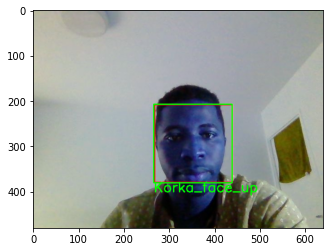

In [ ]:
webcam_face_recognizer(db)

SURVEILLANCE DE L'EXAMEN
--

Fonction permettant de lancer la vidéo, extraire en temps réel les images de la vidéo puis renvoyer l'identité de la personne se trouvant dans la dernière image extraite

In [77]:
# Reconnaissance du visage en temps réel dans une vidéo
# Avec identification du candidat
def reconnaissanceVisageEnTempsreel(bdd):
  video_stream()
  # label for video
  label_html = 'Capturing...'
  # initialze bounding box to empty
  bbox = ''
  count = 0 

  while True:
      js_reply = video_frame(label_html, bbox)
      if not js_reply:
          break

      # convert JS response to OpenCV Image
      img = js_to_image(js_reply["img"])

      # create transparent overlay for bounding box
      bbox_array = np.zeros([480,640,4], dtype=np.uint8)

      # grayscale image for face detection
      gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

      # get face region coordinates
      faces = face_cascade.detectMultiScale(gray)

      
      # get face bounding box for overlay
      ready_to_detect_identity = False
      for (x,y,w,h) in faces:
        bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,255,0),2)
        imgcrop,image = auto_crop_image2(img)
        pool = Pool(processes=1)
        name, ready_to_detect_identity = pool.apply_async(recognize_image, [image, bdd]).get()
        cv2.putText(img = bbox_array, text = name, org = (int(x),int(y+h+20)), fontFace = cv2.FONT_HERSHEY_SIMPLEX, thickness= 2, fontScale = 1, color = (0, 0, 255))
        pool.close()
        print(name)
      
      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      # convert overlay of bbox into bytes
      bbox_bytes = bbox_to_bytes(bbox_array)
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes 
  #"""

L'appel de la fonction ci-dessous lance un enregistrement vidéo à partir de la webcam. Une analyse des visages se fait en même temps que la vidéo.
Chaque fois qu'un visage se trouvant dans la base est détecté, un message s'affiche disant que le visage est détecté.
Pour arrêter la vidéo, on clique dessus et l'image du dernier frame extrait est renvoyé.

In [118]:
reconnaissanceVisageEnTempsreel(db)

<IPython.core.display.Javascript object>

MICHEL


11. AFFICHAGE DE LA PHOTO PRISE PAR LA CAMERA AVEC LE CADRAGE




12. DETECTION DU MOUVEMENT DU VISAGE


In [119]:
# Reconnaissance du visage en temps réel dans une vidéo
# Avec identification du candidat
def detectionMouvementEnTempsReel(bdd):
  video_stream()
  # label for video
  label_html = 'Capturing...'
  # initialze bounding box to empty
  bbox = ''
  count = 0 

  while True:
      js_reply = video_frame(label_html, bbox)
      if not js_reply:
          break

      # convert JS response to OpenCV Image
      img = js_to_image(js_reply["img"])

      # create transparent overlay for bounding box
      bbox_array = np.zeros([480,640,4], dtype=np.uint8)
      #bbox_array = np.zeros(shape=(img.shape), dtype=np.uint8)

      # grayscale image for face detection
      gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

      # get face region coordinates
      faces = face_cascade.detectMultiScale(gray)
      faces2=detector(gray)
      
      # get face bounding box for overlay
      ready_to_detect_identity = False

      for face in faces:
        x = face[0]
        y = face[1]
        w = face[2]
        h = face[3]
        bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,255,0),2)
        imgcrop,image = auto_crop_image2(img)
        pool = Pool(processes=1)
        name, ready_to_detect_identity = pool.apply_async(recognize_image, [image, bdd]).get()
        cv2.putText(img = bbox_array, text = name, org = (int(x),int(y+h+20)), fontFace = cv2.FONT_HERSHEY_SIMPLEX, thickness= 2, fontScale = 1, color = (0, 0, 255))
        pool.close()
        #print(name)

      #
      #if faces2 is not None:
      #  i=np.zeros(shape=(img.shape), dtype=np.uint8)
      for face in faces2:
        landmarks=predictor(gray, face)
        d_eyes=math.sqrt(math.pow(landmarks.part(36).x-landmarks.part(45).x, 2)+math.pow(landmarks.part(36).y-landmarks.part(45).y, 2))
        d1=math.sqrt(math.pow(landmarks.part(36).x-landmarks.part(30).x, 2)+math.pow(landmarks.part(36).y-landmarks.part(30).y, 2))
        d2=math.sqrt(math.pow(landmarks.part(45).x-landmarks.part(30).x, 2)+math.pow(landmarks.part(45).y-landmarks.part(30).y, 2))
        coeff=d1+d2

        a1=int(250*(landmarks.part(36).y-landmarks.part(45).y)/coeff)
        a2=int(250*(d1-d2)/coeff)
        cosb=min((math.pow(d2, 2)-math.pow(d1, 2)+math.pow(d_eyes, 2))/(2*d2*d_eyes), 1)
        a3=int(250*(d2*math.sin(math.acos(cosb))-coeff/4)/coeff)

        for n in range(0, 68):
            x=landmarks.part(n).x
            y=landmarks.part(n).y
            if n==30 or n==36 or n==45:
                cv2.circle(bbox_array, (x, y), 3, (0, 0, 0), -1)
            else:
                cv2.circle(bbox_array, (x, y), 3, (0, 0, 0), -1)
        #print("{:+05d} {:+05d} {:+05d}".format(a1, a2, a3))

        flag=1
        txt=" Regarde "
        if a2<-40:
          txt+="à droite "
          flag=0
        if a2>40:
          txt+="à gauche "
          flag=0
        if a3<-10:
          txt+="en haut "
          flag=0
        if a3>10:
          txt+="en bas "
          flag=0
        if flag:
          txt+="la camera "
        if a1<-40:
          txt+="et incline la tete a gauche "
        if a1>40:
          txt+="et incline la tete a droite "
        print(txt)
        cv2.putText(bbox_array, txt, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 0, 0), 2) 
      
      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      # convert overlay of bbox into bytes
      bbox_bytes = bbox_to_bytes(bbox_array)
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes 
  #"""

In [120]:
detectionMouvement(db)

<IPython.core.display.Javascript object>

 Regarde la camera 
 Regarde à droite en bas et incline la tete a droite 
 Regarde la camera 
 Regarde la camera 


In [ ]:
# Create the haar cascade
leCascade = cv2.CascadeClassifier('/content/drive/MyDrive/opencv/data/haarcascades_cuda/haarcascade_lefteye_2splits.xml')
reCascade = cv2.CascadeClassifier('/content/drive/MyDrive/opencv/data/haarcascades_cuda/haarcascade_righteye_2splits.xml')

In [ ]:
# Read the image
image = cv2.imread("/content/drive/MyDrive/BanqueDesImages/Dehbia/0b6c7844-86b5-4611-8afd-b40df78eba85.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

(1024, 768, 3)


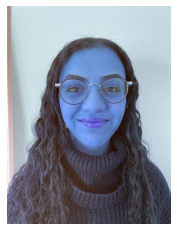

In [ ]:
# affichage des caractéristiques de l'image
print (image.shape)
# affichage de l'image
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
size = image.size
print(size)

2359296


In [ ]:
def findRightEye(image):
    # Detect left eyes in the image
    righteyes = reCascade.detectMultiScale(
        image,
        scaleFactor=1.2,
        minNeighbors=5,
        minSize=(80, 50),
        flags = cv2.CASCADE_SCALE_IMAGE
    )
    return righteyes

def findLeftEye(image):
    # Detect left eyes in the image
    lefteyes = leCascade.detectMultiScale(
        image,
        scaleFactor=1.2,
        minNeighbors=5,
        minSize=(80, 50),
        flags = cv2.CASCADE_SCALE_IMAGE
    )
    return lefteyes

In [ ]:
righteyes = findRightEye(gray)
print ('found ' + str(len(righteyes)) + ' right eye (green)')
print (righteyes)
for (x, y, w, h) in righteyes:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 10) # Draw a rectangle around the eye

lefteyes = findLeftEye(gray)
print ('found '+str(len(lefteyes))+' left eyes (blue)')
print (lefteyes)
for (x, y, w, h) in lefteyes:
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 10) # Draw a rectangle around the eye

found 1 right eye (green)
[[269 320 107 107]]
found 2 left eyes (blue)
[[434 317 109 109]
 [277 324 104 104]]


-1

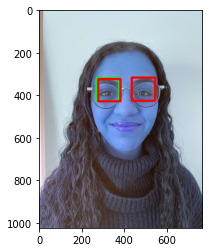

In [ ]:
%matplotlib inline
plt.imshow(image)
cv2.waitKey(0)

13. Deuxième caméra (Téléphone) 

In [ ]:
!pwd
!ls /content/drive/MyDrive/OLSPE/

/content/drive/MyDrive/OLSPE
'Copie de ReconnaissanceFaciale2.ipynb'
 darknet
 datasets.py
 face
 head-pose-estimation
 hopenet_robust_alpha1.pkl
 models
 models.py
 OLSPE
 photo.jpg
 __pycache__
 ReconnaissanceFaciale2.ipynb
 shape_predictor_68_face_landmarks.dat
 shape_predictor_68_face_landmarks.dat.bz2
 tf-keras-deep-head-pose
 utils.py


13.1 Importations de librairies suppléméntaires

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 14730 (delta 2), reused 7 (delta 2), pack-reused 14722
Receiving objects: 100% (14730/14730), 13.28 MiB | 24.81 MiB/s, done.
Resolving deltas: 100% (10017/10017), done.


In [ ]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [ ]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

In [ ]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2021-03-02 17:43:40--  https://docs.google.com/uc?export=download&confirm=aBpy&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 74.125.20.113, 74.125.20.101, 74.125.20.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-2c-docs.googleusercontent.com/docs/securesc/bqqt7enjb6qqs3divprej4d1634nbtge/5mt96amm3apb252982fsd0hdhok5p8fk/1614706950000/17800843676226924807/05307542062694623241Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download [following]
--2021-03-02 17:43:40--  https://doc-10-2c-docs.googleusercontent.com/docs/securesc/bqqt7enjb6qqs3divprej4d1634nbtge/5mt96amm3apb252982fsd0hdhok5p8fk/1614706950000/17800843676226924807/05307542062694623241Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download
Resolving doc-10-2c-docs.googleusercontent.com (doc-10-2c-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to 

In [ ]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

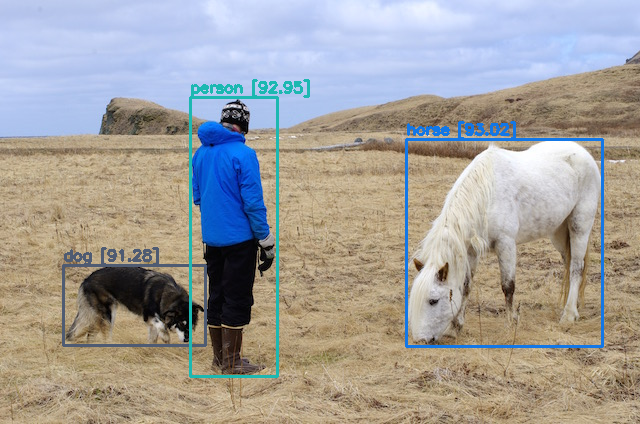

In [ ]:
# run test on person.jpg image that comes with repository
image = cv2.imread("data/person.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


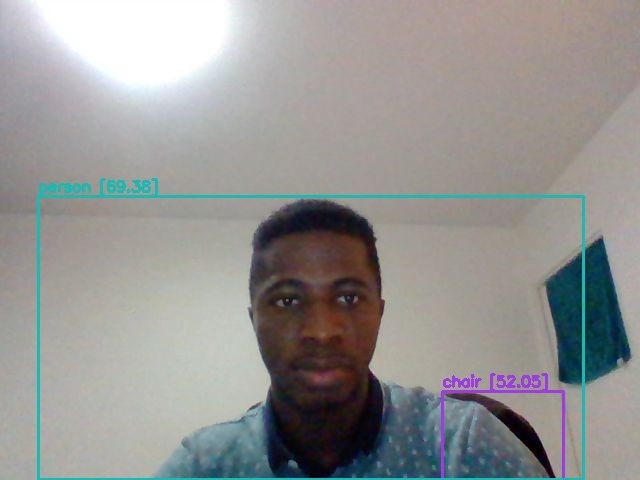

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

14. DETECTION DE LA VOIX (En cours ...)


In [ ]:
!pip install SpeechRecognition

     |████████████████████████████████| 32.8MB 102kB/s 


In [ ]:
!pip install ffmpeg-python

In [ ]:
import speech_recognition as sr
r = sr.Recognizer()
harvard = sr.AudioFile('/content/drive/MyDrive/OLSPE/python-speech-recognition/audio_files/harvard.wav')
with harvard as source:
  audio = r.record(source)
r.recognize_google(audio,show_all=True)

{'alternative': [{'confidence': 0.84245771,
   'transcript': 'the stale smell of old beer lingers it takes heat to bring out the odor a cold dip restores health and zest a salt pickle taste fine with ham tacos al Pastore are my favorite a zestful food is be hot cross bun'},
  {'transcript': 'the stale smell of old beer lingers it takes heat to bring out the odor a cold dip restores health and zest a salt pickle taste fine with ham tacos al Pastore are my favorite a zestful food is the hot cross bun'},
  {'transcript': 'the stale smell of old beer lingers it takes heat to bring out the odor a cold dip restores health and zest a salt pickle taste fine with ham tacos al Pastore are my favorite a zestful food is B hot cross bun'},
  {'transcript': 'the stale smell of old beer lingers it takes heat to bring out the Oder a cold dip restores health and zest a salt pickle taste fine with ham tacos al Pastore are my favorite a zestful food is be hot cross bun'},
  {'transcript': 'the stale smel

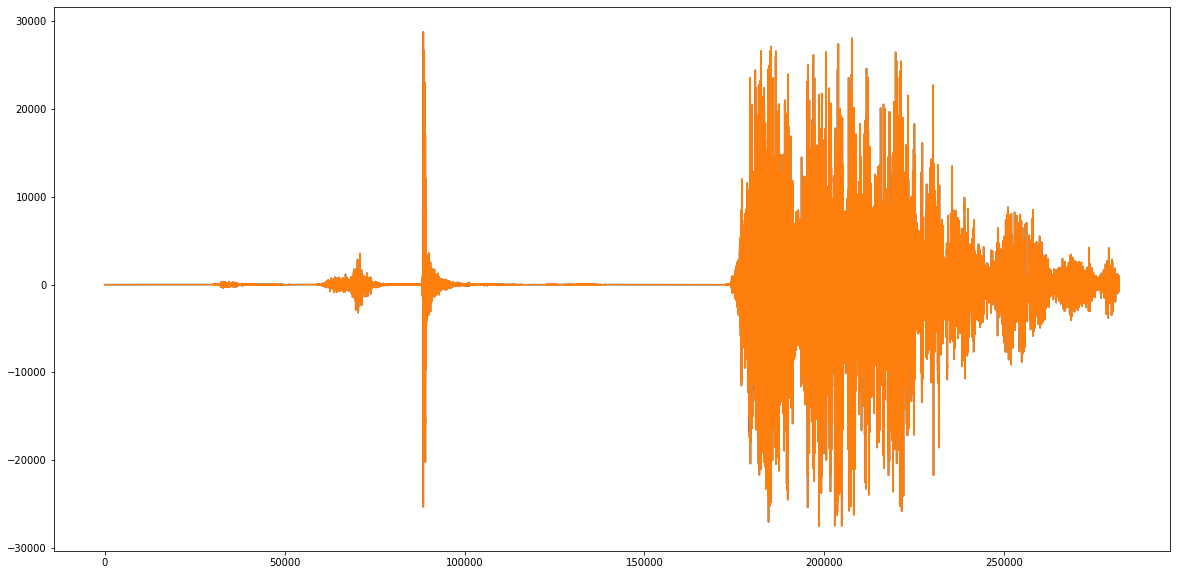

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
from scipy.io.wavfile import write as wav_write
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  #save audio file
  samplerate = 44100; fs = 100
  t = np.linspace(0., 1., samplerate)
  amplitude = np.iinfo(np.int16).max
  #data = amplitude * np.sin(2. * np.pi * fs * t)
  #wav_write("me.wav",samplerate,io.BytesIO(riff).astype(np.int16))
  return audio, sr


audio, sr = get_audio()
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(audio)
plt.show()

In [ ]:
import speech_recognition as sr
r = sr.Recognizer()
korka = sr.AudioFile("/content/drive/MyDrive/OLSPE/python-speech-recognition/audio_files/harvard.wav")  
with korka as source:
  audio = r.listen(source)
r.recognize_google(audio, language="fr-FR")
#r.recognize_google(audio,show_all=True)

'Dustin Hoffman'

FIN DE L'EXAMEN
--